<a href="https://colab.research.google.com/github/bitnetservices/datasciencecoursera/blob/master/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Pre-requisites 
!pip install dgl
!pip install torch 
!pip install matplotlib


     |████████████████████████████████| 3.6MB 5.3MB/s 


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
%matplotlib inline  

from IPython.display import HTML

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving karate.gml to karate.gml
User uploaded file "karate.gml" with length 4194 bytes


FileNotFoundError: ignored

In [5]:
g = nx.read_gml('karate.gml', label='id')

In [6]:
print (nx.info(g))

Name: 
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


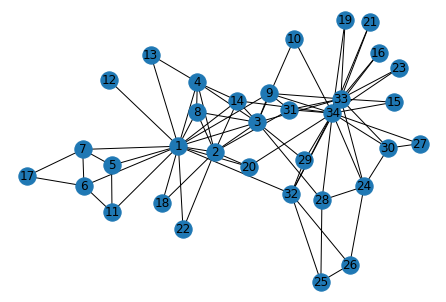

We have 34 nodes.
We have 78 edges.


In [9]:
nx.draw(g, with_labels=True)
plt.show()
print('We have %d nodes.' % g.number_of_nodes())
print('We have %d edges.' % g.number_of_edges())

In [10]:

eye=np.eye(34)

node_label = {}
for i in range(g.number_of_nodes()):
    node_label[i]=eye[i,:]
nx.set_node_attributes(g,node_label,'feature')


print(len(g.nodes))
print(len(g.edges))
print(g.number_of_nodes())
print(g.number_of_edges())


listnodes = list(g.nodes(data='feature'))
n=listnodes[0]
print(n)
print(n[1].shape)

34
78
34
78
(1, array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(34,)


In [ ]:
nodelist, nodesfeatures = map(list, zip(*g.nodes(data='feature')))
print(len(nodesfeatures))
nodesfeatures = np.array(nodesfeatures, dtype="object")
print(nodesfeatures.shape)
nodesfeatures = torch.from_numpy(nodesfeatures).float()
adjacencymatrix = np.array(nx.adjacency_matrix(g, nodelist=nodelist).todense())
print(adjacencymatrix.shape)
adjacencymatrix = torch.from_numpy(adjacencymatrix).float()

In [ ]:
#inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
print(labeled_nodes)
labels = torch.tensor([0, 1])  # their labels are different
print(labels)

In [ ]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
  """
     Graph convolution layer
  """
  
  def __init__(self, in_features, out_features, bias=True, batchnorm=False):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    self.fc = nn.Linear(4*self.in_features, self.out_features, bias=self.bias)
    
    self.batchnorm = batchnorm
    
      
  #H are node features for all graphs batch
  #W are adjacency matrix for all graphs batch
  #A is the set of operators
  # GraphConv = A[0].H_0.W_0 
  def forward(self, H, A):
    res = torch.zeros((H.shape[0],self.in_features*4))
     
    
    output1 = torch.matmul(A[0], H)
    res[:,0:self.in_features]=output1
    
    output2 = torch.matmul(A[1], H)
    res[:,self.in_features:2*self.in_features]=output2
    
    output3 = torch.matmul(A[2], H)
    res[:,2*self.in_features:3*self.in_features]=output3
    
    output4 = torch.matmul(A[3], H)
    res[:,3*self.in_features:4*self.in_features]=output4

    #FC is just a linear function input multiplied by the paramaters W
    output = self.fc(res)
    
    return output

In [ ]:
class Net(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Net, self).__init__()
    self.layers = nn.ModuleList([
        GraphConvolution(in_dim, hidden_dim),
        GraphConvolution(hidden_dim, n_classes)])
    
  def forward(self, h, adj):
    # Add self connections to the adjacency matrix
    id = torch.eye(h.shape[0])
    adj2=torch.pow(adj,2)
    adj3=torch.pow(adj,3)
    #one = torch.ones(h.shape[0])
    for conv in self.layers:
      h = F.relu(conv(h, [id,adj,adj2,adj3]))
    
    
    return h

In [ ]:
nb_channels=34 
num_class=2
num_hidden=5
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
optimizer.zero_grad()
for epoch in range(30):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    # we only compute loss for labeled nodes
    loss0 = lossfunction(prediction[labeled_nodes], labels.long())
    loss=loss0
    #The crossentropy loss does the same as 
    #logp = F.log_softmax(prediction, 1)
    #loss0 = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
    
"""
Epoch 0 | Loss: 0.5651
Epoch 1 | Loss: 0.3199
Epoch 2 | Loss: 0.1667
Epoch 3 | Loss: 0.0628
Epoch 4 | Loss: 0.0201
Epoch 5 | Loss: 0.0060
Epoch 6 | Loss: 0.0021
Epoch 7 | Loss: 0.0008
Epoch 8 | Loss: 0.0003
Epoch 9 | Loss: 0.0001
Epoch 10 | Loss: 0.0001
Epoch 11 | Loss: 0.0000
Epoch 12 | Loss: 0.0000
Epoch 13 | Loss: 0.0000
Epoch 14 | Loss: 0.0000
Epoch 15 | Loss: 0.0000
Epoch 16 | Loss: 0.0000
Epoch 17 | Loss: 0.0000
Epoch 18 | Loss: 0.0000
Epoch 19 | Loss: 0.0000
Epoch 20 | Loss: 0.0000
Epoch 21 | Loss: 0.0000
Epoch 22 | Loss: 0.0000
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000
"""

In [ ]:
#Gif
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()

In [ ]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

"""
Gif path:
https://drive.google.com/file/d/1ppBi3w4oFOR_m6ipz_upU8khLMmT8EpY/view?usp=sharing
"""